# DQN-Sarsa

## Features
* Discrete action space
* Input: length of state space (1D state)
* Ouput: length of action space

## Test env
* InvertedPendulumMuJoCoEnv-v0 **[Solved]**
* HalfCheetahMuJoCoEnv-v0 **[Solved]**
* Breakout-ram-v4 **[Solved]**


In [1]:
# load gym envs and common functions
from utils import *

In [2]:
# Sample tuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

    
# DQN like Sarsa
# Discrete action space and 1D state vector
class DQNSarsa:
    def __init__(self, net, opt, actions, device, gamma=0.99, epsilon=0.1):
        self.name = "DQNSarsa"
        self.policy = net
        self.opt = opt
        self.gamma = gamma
        self.actions = actions
        self.device = device
        self.epsilon = epsilon
        
    def load(self, data):
        self.policy.load_state_dict(data['policy'])
        
    def save(self):
        return {'policy': self.policy.state_dict()}
    
    def prep(self, s):
        return torch.from_numpy(s).float().view(1, -1).to(self.device)
    
    def forward(self, s):
        with torch.no_grad():
            return self.policy(self.prep(s)).max(1)[1][0]

    def e_greedy(self, s, epsilon):
        action_len = len(self.actions)
        p = np.ones(action_len) * epsilon / action_len
        p[self.forward(s)] += 1 - epsilon
        return np.random.choice(action_len, p=p)
        
    def best(self, s):
        return self.actions[self.e_greedy(s, self.epsilon)]
        
    def train(self, transitions):
        s, a, r, sp, done = zip(*transitions)
        
        s = torch.cat([self.prep(i) for i in s], axis=0).to(self.device) # m * n
        sp = torch.cat([self.prep(i) for i in sp], axis=0).to(self.device) # m * n
        r = torch.Tensor([r]).view(-1, 1).to(self.device)
        a = torch.Tensor([a]).long().view(-1, 1).to(self.device)
        done = torch.Tensor([done]).view(-1, 1).to(self.device) 
        
        with torch.no_grad():
            next_q = self.policy(sp).max(1)[0].unsqueeze(1)
        target_q = r + self.gamma * next_q * (1 - done)

        current_q = self.policy(s).gather(1, a)
        loss = F.mse_loss(current_q, target_q)
        
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()


def dqn_sarsa_learning(env_name, agent, config, seed=0):
    set_seeds(seed)
    
    # init env
    env = gym.make(env_name)
    print("Env:", env_name)
    print("Action space:", env.action_space)
    print("Obs space:", env.observation_space)
    print("Agent:", agent.name)
    
    epoch, rewards, max_reward = load_state(env_name, agent)
    print(f"Start at epoch {epoch}, max_reward: {max_reward}")
    
    batch_size = config.get('batch_size', 32)
    
    # update network count
    train_count = 0
    
    # start training and test
    while epoch < config.get('max_epoch', 5000):
        try:
            loss = []
            memory = []
            
            # learning
            obs = env.reset()
            for i in range(config.get('max_step', 1000)):
                s = obs.ravel()
                a = agent.e_greedy(s, agent.epsilon)
                # One step
                obs, r, done, _ = env.step(agent.actions[a])

                memory.append(Transition(s, a, r, obs.ravel(), 1 if done else 0))     
                if done:
                    break

            np.random.shuffle(memory)
            # training
            while len(memory) >= batch_size:
                loss_ = agent.train(memory[:batch_size])
                loss.append(loss_)
                memory = memory[batch_size:]
                train_count += 1
            if len(memory) > 1:
                loss_= agent.train(memory)
                loss.append(loss_)
                train_count += 1
            
            # test
            test_reward = 0
            obs = env.reset()
            for i in range(config.get('max_step', 1000)):
                s = obs.ravel()
                a = agent.best(s)
                obs, r, done, _ = env.step(a)
                test_reward += r
                if done:
                    break
            
            # save reward
            rewards.append(test_reward)
            print(f"Epoch {epoch} | Avg loss: {np.mean(loss)} | Test reward: {test_reward:.1f}")

            # save states
            if test_reward >= max_reward or epoch % config.get('save_interval', 100) == 0:
                max_reward = max(test_reward, max_reward)
                save_state(env_name, agent, f'-{epoch}', epoch, rewards)
            
            epoch += 1
        except KeyboardInterrupt:
            break
        except:
            traceback.print_exc()
            break
    save_state(env_name, agent, '', epoch, rewards)
    # clean up
    env.close()
    # plot rewards
    draw_training_rewards(f"{agent.name} - {env_name}", rewards, config['plt_smooth'])

###  Env 1 InvertedPendulumMuJoCoEnv-v0

In [3]:
# Initialize network, optimizer and agent

config = {
    "save_interval": 500,
    "max_epoch": 150000,
    "max_step": 1000,
    "epsilon": 0.1,
    "gamma": 0.99,   # discount factor
    "lr": 0.0001,     # learning rate
    "batch_size": 128,
    "plt_smooth": 1,
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 3-layer FC network
from model.FCN3 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[-1], [0], [1]]
net = FCN3(4, len(actions), 32).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = DQNSarsa(net, opt, actions, device, gamma=config['gamma'], epsilon=config['epsilon'])

In [ ]:
# train agent
dqn_sarsa_learning("InvertedPendulumMuJoCoEnv-v0", agent, config)

current_dir=/home/xine/.local/lib/python3.6/site-packages/pybullet_envs/bullet
options= 
Test DQNSarsa at epoch 125499, max_reward: 1000.0
options= 
Test 1 | Step: 1000 | Test reward: 1000.0
Test 2 | Step: 1000 | Test reward: 1000.0
Test 3 | Step: 1000 | Test reward: 1000.0
Test 4 | Step: 1000 | Test reward: 1000.0
Test 5 | Step: 1000 | Test reward: 1000.0
Test 6 | Step: 1000 | Test reward: 1000.0
Test 7 | Step: 1000 | Test reward: 1000.0
Test 8 | Step: 1000 | Test reward: 1000.0
Test 9 | Step: 1000 | Test reward: 1000.0
Test 10 | Step: 1000 | Test reward: 1000.0
Mean reward: 1000.0.


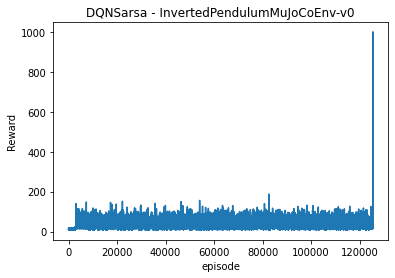

In [4]:
# evaluate agent
evaluate_agent("InvertedPendulumMuJoCoEnv-v0", agent, config)

###  Env 2 HalfCheetahMuJoCoEnv-v0

In [5]:
config = {
    "save_interval": 500,
    "max_epoch": 40000,
    "max_step": 200,
    "epsilon": 0.1,
    "gamma": 0.99,   # discount factor
    "lr": 0.00005,     # learning rate
    "batch_size": 32,
    "plt_smooth": 11,
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 5-layer FC network
from model.FCN5 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[j1, j2, j3, j4, j5, j6] for j1 in range(-1, 2)
           for j2 in range(-1, 2)
           for j3 in range(-1, 2)
           for j4 in range(-1, 2)
           for j5 in range(-1, 2)
           for j6 in range(-1, 2)]
net = FCN5(17, len(actions), 128).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = DQNSarsa(net, opt, actions, device, gamma=config['gamma'])

In [ ]:
# train agent
dqn_sarsa_learning("HalfCheetahMuJoCoEnv-v0", agent, config)

WalkerBase::__init__
options= 
Test DQNSarsa at epoch 32231, max_reward: 156.96062803013177
options= 
Test 1 | Step: 1000 | Test reward: 325.5
Test 2 | Step: 1000 | Test reward: 485.4
Test 3 | Step: 1000 | Test reward: 281.6
Test 4 | Step: 1000 | Test reward: 370.1
Test 5 | Step: 1000 | Test reward: -280.3
Test 6 | Step: 1000 | Test reward: 462.9
Test 7 | Step: 1000 | Test reward: 515.8
Test 8 | Step: 1000 | Test reward: 338.0
Test 9 | Step: 1000 | Test reward: 379.1
Test 10 | Step: 1000 | Test reward: 499.3
Mean reward: 337.8.


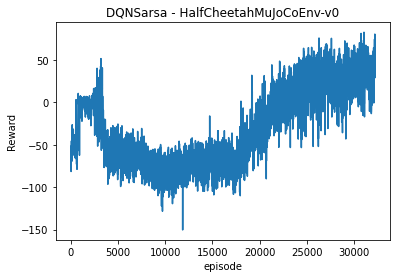

In [6]:
# test agent
evaluate_agent("HalfCheetahMuJoCoEnv-v0", agent, config)

###  Env 3 Breakout-ram-v4

In [7]:
config = {
    "save_interval": 500,
    "max_epoch": 50000,
    "max_step": 1000,
    "epsilon": 0.1,
    "gamma": 0.99,   # discount factor
    "lr": 0.00005,     # learning rate
    "batch_size": 32,
    "plt_smooth": 1,
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 5-layer FC network
from model.FCN5 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[0], [1], [2], [3]]
net = FCN5(128, len(actions), 128).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = DQNSarsa(net, opt, actions, device, gamma=config['gamma'])

def normalized_prep(self, s):
    val = torch.from_numpy(s).float() / 255
    return val.view(1, -1).to(self.device)

import types
agent.prep=types.MethodType(normalized_prep, agent)

In [ ]:
# train agent
dqn_sarsa_learning("Breakout-ram-v4", agent, config)

Test DQNSarsa at epoch 17808, max_reward: 20.0
Test 1 | Step: 422 | Test reward: 5.0
Test 2 | Step: 542 | Test reward: 7.0
Test 3 | Step: 538 | Test reward: 7.0
Test 4 | Step: 458 | Test reward: 6.0
Test 5 | Step: 477 | Test reward: 6.0
Test 6 | Step: 542 | Test reward: 8.0
Test 7 | Step: 467 | Test reward: 6.0
Test 8 | Step: 491 | Test reward: 7.0
Test 9 | Step: 472 | Test reward: 6.0
Test 10 | Step: 484 | Test reward: 6.0
Mean reward: 6.4.


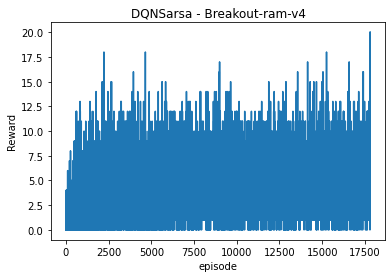

In [9]:
# test agent
evaluate_agent("Breakout-ram-v4", agent, config)